Version A: Base LightGBM w/ early stopping (logloss)

In [1]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import log_loss, accuracy_score
# from lightgbm import LGBMClassifier, early_stopping, log_evaluation
# import pandas as pd
# import numpy as np

# # Version label
# version_name = 'Version A: Base LGBM (NoAmenities Removed)'

# # Load data
# train = pd.read_csv('../data/train_clean.csv')
# test = pd.read_csv('../data/test_clean.csv')

# # Drop 'NoAmenities' as specified for Version A
# X_full = train.drop(columns=['Transported', 'NoAmenities'])
# y = train['Transported'].astype(int)
# X_test_full = test.drop(columns=['NoAmenities'])

# # Get list of categorical columns
# cat_cols = X_full.select_dtypes(include='object').columns.tolist()
# X_test_full[cat_cols] = X_test_full[cat_cols].astype('category')

# # Set up cross-validation
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# oof_preds = np.zeros(len(X_full))
# test_preds = np.zeros(len(X_test_full))

# # Cross-validation loop
# for fold, (train_idx, val_idx) in enumerate(cv.split(X_full, y)):
#     X_train, y_train = X_full.iloc[train_idx].copy(), y.iloc[train_idx]
#     X_val, y_val = X_full.iloc[val_idx].copy(), y.iloc[val_idx]

#     # Fold-specific categorical columns (safe typing)
#     cat_features = X_train.select_dtypes(include='object').columns.tolist()
#     for col in cat_features:
#         X_train[col] = X_train[col].astype('category')
#         X_val[col] = X_val[col].astype('category')

#     # Align test set columns with training set
#     X_test_fold = X_test_full[X_train.columns]

#     # Define LightGBM model
#     model = LGBMClassifier(
#         learning_rate=0.05,
#         n_estimators=1000,
#         max_depth=6,
#         num_leaves=32,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         random_state=42
#     )

#     # Train with early stopping
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         categorical_feature=cat_features,
#         eval_metric='logloss',
#         callbacks=[
#             early_stopping(stopping_rounds=50),
#             log_evaluation(period=0)  # silent
#         ]
#     )

#     # Predict
#     oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
#     test_preds += model.predict_proba(X_test_fold)[:, 1] / cv.n_splits

#     fold_loss = log_loss(y_val, oof_preds[val_idx])
#     print(f'Fold {fold + 1} Log Loss: {fold_loss:.5f}')

# # Final evaluation
# total_loss = log_loss(y, oof_preds)
# accuracy = accuracy_score(y, oof_preds > 0.5)
# print(f'\n{version_name}')
# print(f'Overall CV Log Loss: {total_loss:.5f}')
# print(f'Accuracy: {accuracy:.4f}')

# import matplotlib.pyplot as plt
# import lightgbm as lgb

# lgb.plot_importance(model, max_num_features=20, importance_type='gain')
# plt.title("VA - Feature Importance (gain)")
# plt.show()

Version B: NoAmenities Only

In [2]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import log_loss, accuracy_score
# from lightgbm import LGBMClassifier, early_stopping, log_evaluation
# import pandas as pd
# import numpy as np

# # Version label
# version_name = 'Version B: LGBM with NoAmenities Only'

# # Load data
# train = pd.read_csv('../data/train_clean.csv')
# test = pd.read_csv('../data/test_clean.csv')

# # Drop the 5 individual spend features
# drop_spend = ['TotalSpend','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# X_full = train.drop(columns=['Transported'] + drop_spend)
# y = train['Transported'].astype(int)
# X_test_full = test.drop(columns=drop_spend)

# # Ensure NoAmenities is kept
# assert 'NoAmenities' in X_full.columns

# # Get categorical columns
# cat_cols = X_full.select_dtypes(include='object').columns.tolist()
# X_test_full[cat_cols] = X_test_full[cat_cols].astype('category')

# # Set up cross-validation
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# oof_preds = np.zeros(len(X_full))
# test_preds = np.zeros(len(X_test_full))

# # Cross-validation loop
# for fold, (train_idx, val_idx) in enumerate(cv.split(X_full, y)):
#     X_train, y_train = X_full.iloc[train_idx].copy(), y.iloc[train_idx]
#     X_val, y_val = X_full.iloc[val_idx].copy(), y.iloc[val_idx]

#     # Categorical casting per fold
#     cat_features = X_train.select_dtypes(include='object').columns.tolist()
#     for col in cat_features:
#         X_train[col] = X_train[col].astype('category')
#         X_val[col] = X_val[col].astype('category')

#     X_test_fold = X_test_full[X_train.columns]

#     # Model
#     model = LGBMClassifier(
#         learning_rate=0.05,
#         n_estimators=1000,
#         max_depth=6,
#         num_leaves=32,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         random_state=42
#     )

#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         categorical_feature=cat_features,
#         eval_metric='logloss',
#         callbacks=[
#             early_stopping(stopping_rounds=50),
#             log_evaluation(period=0)
#         ]
#     )

#     oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
#     test_preds += model.predict_proba(X_test_fold)[:, 1] / cv.n_splits

#     fold_loss = log_loss(y_val, oof_preds[val_idx])
#     print(f'Fold {fold + 1} Log Loss: {fold_loss:.5f}')

# # Final evaluation
# total_loss = log_loss(y, oof_preds)
# accuracy = accuracy_score(y, oof_preds > 0.5)
# print(f'\n{version_name}')
# print(f'Overall CV Log Loss: {total_loss:.5f}')
# print(f'Accuracy: {accuracy:.4f}')

# import matplotlib.pyplot as plt
# import lightgbm as lgb

# lgb.plot_importance(model, max_num_features=20, importance_type='gain')
# plt.title("VB - Feature Importance (gain)")
# plt.show()


Verson C: No changes

In [3]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import log_loss, accuracy_score
# from lightgbm import LGBMClassifier, early_stopping, log_evaluation
# import pandas as pd
# import numpy as np

# # Load data
# train = pd.read_csv('../data/train_clean.csv')
# test = pd.read_csv('../data/test_clean.csv')

# # Separate features and target
# X_full = train.drop(columns=['Transported'])
# y = train['Transported'].astype(int)
# X_test_full = test.copy()

# # Get categorical columns once from full training set (non-leaky)
# cat_cols = X_full.select_dtypes(include='object').columns.tolist()
# X_test_full[cat_cols] = X_test_full[cat_cols].astype('category')  # Pre-convert test set

# # Setup CV
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Store predictions
# oof_preds = np.zeros(len(X_full))
# test_preds = np.zeros(len(X_test_full))

# # Loop over folds
# for fold, (train_idx, val_idx) in enumerate(cv.split(X_full, y)):
#     X_train = X_full.iloc[train_idx].copy()
#     y_train = y.iloc[train_idx]
#     X_val = X_full.iloc[val_idx].copy()
#     y_val = y.iloc[val_idx]

#     # Get categorical columns from training fold (ensures no leakage)
#     cat_features = X_train.select_dtypes(include='object').columns.tolist()

#     # Convert to category dtype for LightGBM
#     for col in cat_features:
#         X_train[col] = X_train[col].astype('category')
#         X_val[col] = X_val[col].astype('category')

#     # Ensure column alignment
#     X_test_fold = X_test_full[X_train.columns]

#     # Initialize and train model
#     model = LGBMClassifier(
#         learning_rate=0.05,
#         n_estimators=1000,
#         max_depth=6,
#         num_leaves=32,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         random_state=42
#     )

#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         categorical_feature=cat_features,
#         eval_metric='logloss',
#         callbacks=[
#             early_stopping(stopping_rounds=50),
#             log_evaluation(period=0)  # silence output
#         ]
#     )

#     # Predict on validation and test
#     oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
#     test_preds += model.predict_proba(X_test_fold)[:, 1] / cv.n_splits

#     # Log fold loss
#     fold_loss = log_loss(y_val, oof_preds[val_idx])
#     print(f'Fold {fold + 1} Log Loss: {fold_loss:.5f}')

# # Final evaluation
# total_loss = log_loss(y, oof_preds)
# accuracy = accuracy_score(y, oof_preds > 0.5)
# print(f'\nOverall CV Log Loss: {total_loss:.5f}')
# print(f'Accuracy: {accuracy:.4f}')

# import matplotlib.pyplot as plt
# import lightgbm as lgb

# lgb.plot_importance(model, max_num_features=20, importance_type='gain')
# plt.title("VC - Feature Importance (gain)")
# plt.show()

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

# Load data
train = pd.read_csv('../data/train_clean.csv')
test = pd.read_csv('../data/test_clean.csv')

# Separate features and target
X_full = train.drop(columns=['Transported'])
y = train['Transported'].astype(int)
X_test_full = test.copy()

# Configurable drop groups - add/remove columns here by group for easy testing
# Group 1: Raw spends (comment out or set [] if keeping them)
drop_raw_spends = []  # ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend', 'LuxurySpend', 'EssentialSpend']

# Group 2: Low-gain features from importance plots (<500 gain)
drop_low_gain = ['VIP_cleaned', 'Cabin_missing', 'Age_confidence', 'Destination_confidence', 'VIP_confidence', 'LikelyBudgetPassenger']  # Add/remove based on plots

# Group 3: Other potential drops (e.g., redundant or noisy - customize as needed)
drop_other = []  # e.g., ['Surname', 'PassengerId'] if still present

# Combine all drop groups into one list
drop_list = drop_raw_spends + drop_low_gain + drop_other
X_full = X_full.drop(columns=drop_list, errors='ignore')
X_test_full = X_test_full.drop(columns=drop_list, errors='ignore')

# Get categorical columns once from full training set (non-leaky)
cat_cols = X_full.select_dtypes(include='object').columns.tolist()
X_test_full[cat_cols] = X_test_full[cat_cols].astype('category')  # Pre-convert test set

# Setup CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store predictions
oof_preds = np.zeros(len(X_full))
test_preds = np.zeros(len(X_test_full))

# Loop over folds
for fold, (train_idx, val_idx) in enumerate(cv.split(X_full, y)):
    X_train = X_full.iloc[train_idx].copy()
    y_train = y.iloc[train_idx]
    X_val = X_full.iloc[val_idx].copy()
    y_val = y.iloc[val_idx]

    # Get categorical columns from training fold (ensures no leakage)
    cat_features = X_train.select_dtypes(include='object').columns.tolist()

    # Convert to category dtype for LightGBM
    for col in cat_features:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')

    # Ensure column alignment
    X_test_fold = X_test_full[X_train.columns]

    # Initialize models
    lgb_model = LGBMClassifier(learning_rate=0.05, n_estimators=1000, max_depth=6, num_leaves=32, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1, reg_lambda=0.1, random_state=42)
    xgb_model = XGBClassifier(learning_rate=0.05, n_estimators=1000, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42, enable_categorical=True, eval_metric='logloss')

    # Fit LGBM with early stopping
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        categorical_feature=cat_features,
        eval_metric='logloss',
        callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(period=0)  # silence output
        ]
    )

    # Fit XGB with early stopping
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=50,
        verbose=False
    )

    # Predict with both models and average probs for ensemble
    lgb_oof = lgb_model.predict_proba(X_val)[:, 1]
    xgb_oof = xgb_model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = (lgb_oof + xgb_oof) / 2

    lgb_test = lgb_model.predict_proba(X_test_fold)[:, 1]
    xgb_test = xgb_model.predict_proba(X_test_fold)[:, 1]
    test_preds += (lgb_test + xgb_test) / (2 * cv.n_splits)

    # Log fold loss
    fold_loss = log_loss(y_val, oof_preds[val_idx])
    print(f'Fold {fold + 1} Log Loss: {fold_loss:.5f}')

# Final evaluation
total_loss = log_loss(y, oof_preds)
accuracy = accuracy_score(y, oof_preds > 0.5)
print(f'\nOverall CV Log Loss: {total_loss:.5f}')
print(f'Accuracy: {accuracy:.4f}')

import pandas as pd
import matplotlib.pyplot as plt

# Get importances from LGBM (since we have individual models)
importances = pd.Series(lgb_model.feature_importances_, index=lgb_model.feature_name_).sort_values(ascending=False)

# Define main groups first
spend_features = [col for col in importances.index if 'Spend' in col or 'log' in col or 'Amenities' in col or 'RoomService' in col or 'FoodCourt' in col or 'ShoppingMall' in col or 'Spa' in col or 'VRDeck' in col]
cabin_features = [col for col in importances.index if 'Cabin' in col or 'Deck' in col or 'Region' in col]
group_family = [col for col in importances.index if 'Group' in col or 'Family' in col or 'Solo' in col]

# Then define 'Other' as the remainder
other_features = [col for col in importances.index if col not in spend_features + cabin_features + group_family]

# Now create the groups dict
groups = {
    'Spend': spend_features,
    'Cabin': cabin_features,
    'Group/Family': group_family,
    'Other': other_features
}

# Sum importances per group
group_importances = {group: importances[features].sum() for group, features in groups.items() if features}

# Plot as heatmap (simple matrix)
df_group = pd.DataFrame.from_dict(group_importances, orient='index', columns=['Importance'])
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(df_group.values, cmap='YlGnBu')
ax.set_yticks(range(len(df_group)), df_group.index)
ax.set_xticks([0], ['Importance'])
plt.colorbar(im, ax=ax)
ax.set_title('Grouped Feature Importance Heatmap')
for i in range(len(df_group)):
    ax.text(0, i, f"{df_group.iloc[i, 0]:.2f}", ha='center', va='center')
plt.show()

# Save submission
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Transported': (test_preds > 0.5).astype(bool)
})
submission.to_csv('../submissions/ensemble_submission.csv', index=False)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6792
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

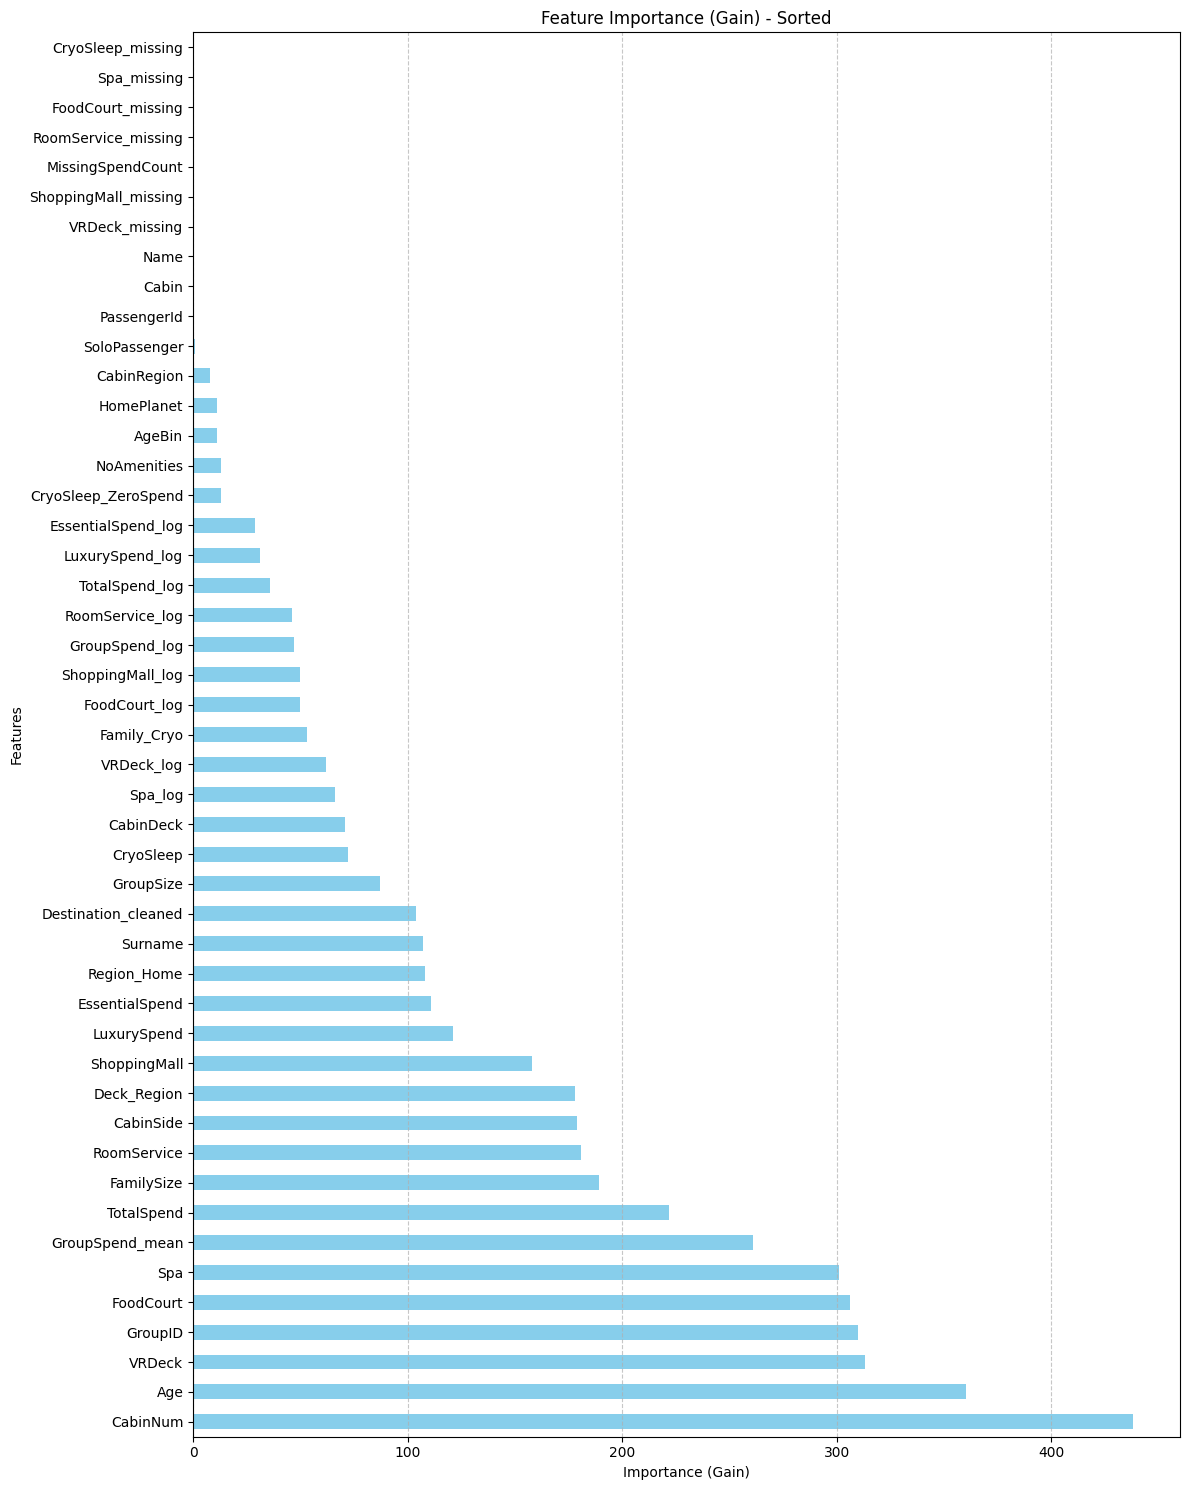

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get importances as DataFrame, sort descending
importances = pd.Series(model.feature_importances_, index=model.feature_name_)
importances = importances.sort_values(ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(12, 15))  # Taller for more features
importances.plot.barh(ax=ax, color='skyblue')
ax.set_title('Feature Importance (Gain) - Sorted')
ax.set_xlabel('Importance (Gain)')
ax.set_ylabel('Features')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjusts spacing
plt.show()